<a href="https://colab.research.google.com/github/kgj1234/StockPredictionNotebook/blob/main/Stock_Price_Forecasting_%E2%80%94_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jacksoncrow_stock_market_dataset_path = kagglehub.dataset_download('jacksoncrow/stock-market-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'stock-market-dataset' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
;
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/stock-market-dataset/stocks/COKE.csv
/kaggle/input/stock-market-dataset/stocks/FDS.csv
/kaggle/input/stock-market-dataset/stocks/KAI.csv
/kaggle/input/stock-market-dataset/stocks/PPBI.csv
/kaggle/input/stock-market-dataset/stocks/CARS.csv
/kaggle/input/stock-market-dataset/stocks/PD.csv
/kaggle/input/stock-market-dataset/stocks/EAE.csv
/kaggle/input/stock-market-dataset/stocks/RCM.csv
/kaggle/input/stock-market-dataset/stocks/AAON.csv
/kaggle/input/stock-market-dataset/stocks/HKIB.csv
/kaggle/input/stock-market-dataset/stocks/CJJD.csv
/kaggle/input/stock-market-dataset/stocks/BIO.csv
/kaggle/input/stock-market-dataset/stocks/PTN.csv
/kaggle/input/stock-market-dataset/stocks/BBAR.csv
/kaggle/input/stock-market-dataset/stocks/OFS.csv
/kaggle/input/stock-market-dataset/stocks/CYCCP.csv
/kaggle/input/stock-market-dataset/stocks/YRCW.csv
/kaggle/input/stock-market-dataset/stocks/CUB.csv
/kaggle/input/stock-market-dataset/stock

''

# Stock Price Forecasting - Time Series
**Author:** Jane Zhang  
**Objective:** Demonstrate time-series modelling skills with exploratory data analysis, feature engineering, classical and advanced models (ARIMA, XGBoost, Prophet, LSTM, Transformer-style), walk-forward evaluation, metrics and ensembling.


# Table of Contents
1. [Imports & Setup](#setup)  
2. [Load data (CSV or yfinance)](#load)  
3. [Exploratory Data Analysis (EDA)](#eda)  
4. [Feature Engineering & Train/Test split](#fe)
5. [Evaluation helpers](#ev)
6. [Baselines: Naive, Persistence, Moving Average](#baselines)  
7. [Classical model: ARIMA / auto_arima](#arima)  
8. [Prophet (or Prophet-like) model](#prophet)  
9. [Tree-based model: XGBoost with lag features](#xgboost)  
10. [Deep learning: LSTM model](#lstm)  
11. [Model ensembling](#ensemble)  
12. [Final predictions](#prediction)  
13. [Conclusions & Next steps](#conclusion)


## 1.Imports & Setup

In [3]:
# Core imports and reproducibility
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)


## 2.Load the dataset
The cell below tries to load `stock_data.csv` from the notebook's input directory (you can upload your CSV). If not found, it downloads data with `yfinance` for a specified ticker and date range.


In [4]:
# Config: change ticker / start / end if desired
TICKER = "AAPL"   # default, change to any symbol
START = "2015-01-01"
END = datetime.today().strftime("%Y-%m-%d")
INPUT_CSV = "/kaggle/input/stock_data.csv"  # optional user-uploaded CSV

def load_data(ticker=TICKER, start=START, end=END, csv_path=INPUT_CSV):
    if os.path.exists(csv_path):
        print("Loading CSV:", csv_path)
        df = pd.read_csv(csv_path, parse_dates=True)
        # Try to standardize common columns
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date').reset_index(drop=True)
            df.set_index('Date', inplace=True)
        return df
    else:
        print(f"No CSV found at {csv_path}. Downloading {ticker} via yfinance.")
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, progress=False)
        df.index = pd.to_datetime(df.index)
        return df

df = load_data()
print(df.shape)
df.head()


No CSV found at /kaggle/input/stock_data.csv. Downloading AAPL via yfinance.


/tmp/ipython-input-1434608297.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


(2721, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261044,24.729267,23.821668,24.718171,212818400
2015-01-05,23.577576,24.110152,23.391175,24.030265,257142000
2015-01-06,23.579790,23.839420,23.218081,23.641924,263188400
2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600
2015-01-08,24.829124,24.886821,24.121242,24.238854,237458000


## 3.Quick EDA
To understand the series behaviour: missing values, trends, seasonality, and volatility. We'll focus on `Close` price for forecasting but keep other columns for features.


Date range: 2015-01-02 00:00:00 to 2025-10-27 00:00:00
Missing values count: Ticker
AAPL    0
dtype: int64


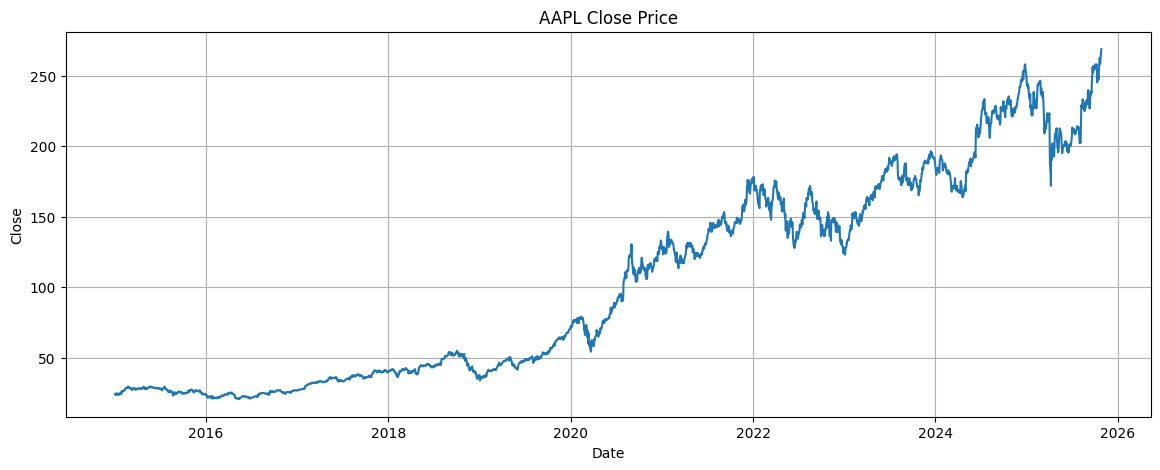

<Figure size 1400x500 with 0 Axes>

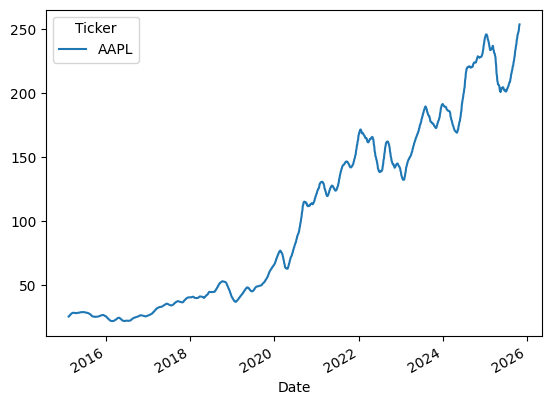

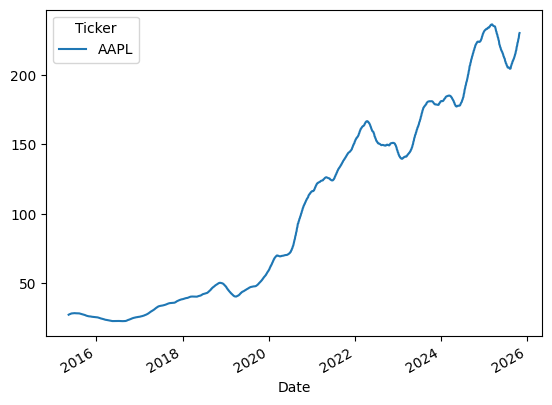

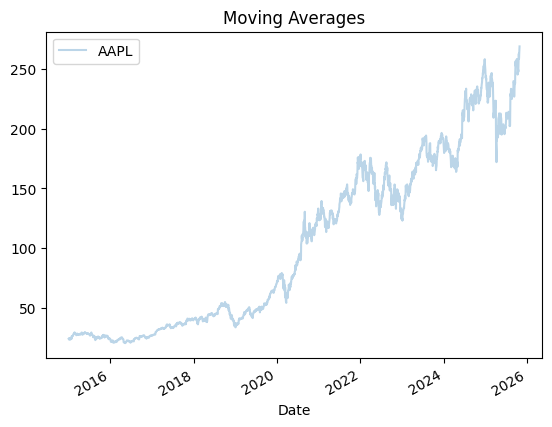

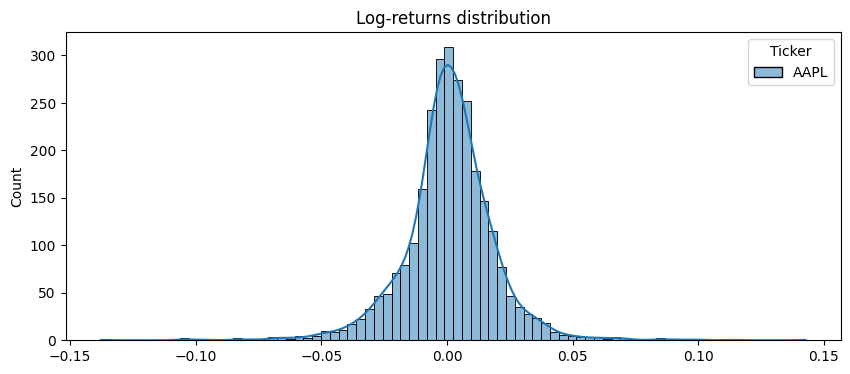

In [5]:
# EDA: summary and plotting
series = df['Close'].copy()
print("Date range:", series.index.min(), "to", series.index.max())
print("Missing values count:", series.isna().sum())

# Simple plot
plt.figure(figsize=(14,5))
plt.plot(series.index, series.values)
plt.title(f"{TICKER} Close Price")
plt.xlabel("Date"); plt.ylabel("Close")
plt.grid(True)
plt.show()

# Rolling statistics
plt.figure(figsize=(14,5))
series.rolling(30).mean().plot(label='30d MA')
series.rolling(90).mean().plot(label='90d MA')
series.plot(alpha=0.3, label='Close')
plt.legend(); plt.title("Moving Averages")
plt.show()

# Log returns distribution
returns = np.log(series).diff().dropna()
plt.figure(figsize=(10,4))
sns.histplot(returns, bins=80, kde=True)
plt.title("Log-returns distribution")
plt.show()


## 4.Feature Engineering & Time-based split
We'll create lag features, rolling statistics, date-based features (day-of-week, month), and a train/validation/test split using chronological (time series aware) partitioning. We also provide functions for reusability.


In [6]:
# Feature engineering helpers
def create_lag_features(df, col='Close', lags=[1,2,3,5,7,14,21], windows=[7,14,21,50]):
    df_feat = df[[col]].copy()
    for l in lags:
        df_feat[f"lag_{l}"] = df_feat[col].shift(l)
    for w in windows:
        df_feat[f"ma_{w}"] = df_feat[col].rolling(w).mean().shift(1)
        df_feat[f"std_{w}"] = df_feat[col].rolling(w).std().shift(1)
    # returns
    df_feat['ret_1'] = df_feat[col].pct_change().shift(1)
    df_feat['logret_1'] = np.log(df_feat[col]).diff().shift(1)
    # date features
    df_feat['dow'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat = df_feat.dropna()
    return df_feat

df_feat = create_lag_features(df, col='Close')
df_feat.shape


(2671, 20)

In [7]:
# Time-aware train/val/test split (e.g., 70/15/15)
def time_train_test_split(df, train_size=0.7, val_size=0.15):
    n = len(df)
    train_end = int(n*train_size)
    val_end = train_end + int(n*val_size)
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

train_df, val_df, test_df = time_train_test_split(df_feat, 0.7, 0.15)
print("Train, Val, Test sizes:", len(train_df), len(val_df), len(test_df))


Train, Val, Test sizes: 1869 400 402


## 5.Evaluation helpers

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_preds(y_true, y_pred, name="model"):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    print(f"Evaluation -> {name}")
    print("RMSE:", rmse(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mape(y_true, y_pred))


## 6.Baselines: Naive, Persistence, Moving Average
**Always include simple baselines.** We'll compute a naive (y[t] = y[t-1]), a persistence that uses previous day, and a simple moving-average prediction. These are quick sanity checks.


In [9]:
# Baselines on validation set
y_val = val_df['Close']
# 1) Naive (last observed closing price)
naive_pred = val_df['lag_1']  # because lag_1 is previous day's close
evaluate_preds(y_val.values, naive_pred.values, "Naive (lag1)")

# 2) Rolling mean baseline using MA_7 as prediction
ma7_pred = val_df['ma_7']
evaluate_preds(y_val.values, ma7_pred.values, "MA7 baseline")


Evaluation -> Naive (lag1)
RMSE: 2.5223134702313854
MAE: 1.8922007751464844
MAPE: 1.1772708122059186
Evaluation -> MA7 baseline
RMSE: 4.250902553437787
MAE: 3.4165332521711083
MAPE: 2.110977797704586


## 7.Classical model: auto_arima
**Auto ARIMA** gives a classical time-series benchmark. We'll fit on the training Close series and forecast the validation horizon. `pmdarima`'s `auto_arima` automates order selection.


In [11]:
# Install pmdarima if missing
# !pip install pmdarima --quiet # Removed as it seems to cause version conflict

# Explicitly install a version compatible with the current numpy
!pip install pmdarima==2.0.3 --quiet

# Fit auto_arima on training Close and forecast length = len(val)
from pmdarima import auto_arima

y_train = train_df['Close']
print("Fitting auto_arima (this may take a few minutes)...")
arima_model = auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_order=10)
print(arima_model.summary())

n_forecast = len(val_df)
arima_pred = arima_model.predict(n_periods=n_forecast)
evaluate_preds(val_df['Close'].values, arima_pred, "AutoARIMA")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.9/630.9 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pmdarima
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pmdarima)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 8.Prophet model
**Prophet** (by Meta) is a handy decomposable model (trend + seasonality + holidays). We'll adapt our dataframe to Prophet's `ds`/`y` format and train. Note: Prophet fits quickly for daily series.


In [12]:
# Install Prophet if missing
!pip install prophet --quiet

from prophet import Prophet

print("\n=== Prophet Model ===")

# Ensure single-column, numeric input
prophet_train = pd.DataFrame({
    'ds': pd.to_datetime(train_df.index),
    'y': train_df['Close'].astype(float).values.flatten()
})

prophet_val = pd.DataFrame({
    'ds': pd.to_datetime(val_df.index),
    'y': val_df['Close'].astype(float).values.flatten()
})

# Initialize and fit Prophet
print("Fitting Prophet model (this may take a minute)...")
model_prophet = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)
model_prophet.fit(prophet_train)

# Create a future DataFrame for validation period
future = prophet_val[['ds']]

# Forecast
forecast = model_prophet.predict(future)

# Predictions and evaluation
prophet_pred = forecast['yhat'].values
evaluate_preds(prophet_val['y'].values, prophet_pred, "Prophet")


=== Prophet Model ===
Fitting Prophet model (this may take a minute)...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkavg5gtv/60_xinwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkavg5gtv/_3m3zrl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15582', 'data', 'file=/tmp/tmpkavg5gtv/60_xinwk.json', 'init=/tmp/tmpkavg5gtv/_3m3zrl7.json', 'output', 'file=/tmp/tmpkavg5gtv/prophet_modelc8h6482k/prophet_model-20251028041007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Evaluation -> Prophet
RMSE: 24.21943272609685
MAE: 20.97885023805251
MAPE: 13.527449518554983


## 9.Tree-based model: XGBoost with lag features
**XGBoost on lag features** often performs strongly for short-term forecasting when framed as supervised learning. We'll train on the engineered features (lags, moving averages) and predict Close.


In [13]:
import xgboost as xgb

# Remove target and ensure numeric features only
FEATURES = [c for c in train_df.columns if c not in ['Close']]

# Convert all features to numeric (timestamps become ordinal numbers)
X_train = train_df[FEATURES].copy()
X_val = val_df[FEATURES].copy()

for df in [X_train, X_val]:
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = df[col].map(pd.Timestamp.toordinal)  # convert dates to numeric
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # convert objects to numeric

y_train = train_df['Close'].values
y_val = val_df['Close'].values

# Convert to numpy arrays
X_train_np = X_train.values
X_val_np = X_val.values

# Create DMatrix
dtrain = xgb.DMatrix(X_train_np, label=y_train)
dval = xgb.DMatrix(X_val_np, label=y_val)

# XGBoost params
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': RSEED,
    'verbosity': 0,
    'max_depth': 6,
    'eta': 0.05
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

# Train
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=50
)

# Predict and evaluate
xgb_pred = xgb_model.predict(dval)
evaluate_preds(y_val, xgb_pred, "XGBoost (lag features)")

[0]	train-rmse:44.73619	val-rmse:95.84839
[50]	train-rmse:3.57959	val-rmse:14.44469
[100]	train-rmse:0.35329	val-rmse:7.24144
[150]	train-rmse:0.14695	val-rmse:6.55482
[200]	train-rmse:0.11652	val-rmse:6.46407
[250]	train-rmse:0.09976	val-rmse:6.45706
[300]	train-rmse:0.08661	val-rmse:6.44911
[350]	train-rmse:0.07581	val-rmse:6.44547
[389]	train-rmse:0.06717	val-rmse:6.44398
Evaluation -> XGBoost (lag features)
RMSE: 6.4439807827444024
MAE: 3.5806752586364747
MAPE: 1.9216255390199257


## 10.Deep Learning: LSTM
**LSTM** sequence-to-one model: we create sliding windows (e.g., 30 days input -> predict next day). This requires a GPU for faster training but will run on CPU (slower). We'll build a reproducible pipeline using TensorFlow/Keras.


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Prepare features and target
# -------------------------------
FEATURES_NUMERIC = FEATURES.copy()
for col in FEATURES_NUMERIC:
    if np.issubdtype(train_df[col].dtype, np.datetime64):
        train_df[col] = train_df[col].map(pd.Timestamp.toordinal)
        val_df[col] = val_df[col].map(pd.Timestamp.toordinal)

X_train_df = train_df[FEATURES_NUMERIC].copy()
y_train = train_df['Close'].values
X_val_df = val_df[FEATURES_NUMERIC].copy()
y_val = val_df['Close'].values

# -------------------------------
# 2. Scale features (target stays numeric)
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_df.index, columns=FEATURES_NUMERIC)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val_df.index, columns=FEATURES_NUMERIC)

# -------------------------------
# 3. Build sequences for LSTM
# -------------------------------
def create_sequences(data_X, data_y, seq_len=30):
    X_seq, y_seq = [], []
    vals_X = data_X.values
    vals_y = data_y
    for i in range(seq_len, len(data_X)):
        X_seq.append(vals_X[i-seq_len:i, :])
        y_seq.append(vals_y[i])
    return np.array(X_seq), np.array(y_seq)

seq_len = 30
X_tr, y_tr = create_sequences(X_train_scaled_df, y_train, seq_len)
X_va, y_va = create_sequences(
    pd.concat([X_train_scaled_df.tail(seq_len), X_val_scaled_df]),
    np.concatenate([y_train[-seq_len:], y_val]),
    seq_len
)

print("LSTM shapes:", X_tr.shape, y_tr.shape, X_va.shape, y_va.shape)

# -------------------------------
# 4. Build and train LSTM model
# -------------------------------
tf.keras.utils.set_random_seed(RSEED)

model_lstm = Sequential([
    LSTM(64, input_shape=(X_tr.shape[1], X_tr.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# -------------------------------
# 5. Evaluate LSTM on validation set
# -------------------------------
lstm_pred = model_lstm.predict(X_va).flatten()
evaluate_preds(y_va, lstm_pred, "LSTM")


LSTM shapes: (1839, 30, 20) (1839, 1) (400, 30, 20) (400, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873 (93.25 KB)

 Trainable params: 23,873 (93.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
58/58 - 4s - 77ms/step - loss: 5957.2671 - mae: 62.5335 - val_loss: 21427.4395 - val_mae: 145.1435
Epoch 2/100
58/58 - 1s - 26ms/step - loss: 3394.5430 - mae: 40.2356 - val_loss: 12672.4092 - val_mae: 110.9569
Epoch 3/100
58/58 - 1s - 22ms/step - loss: 1344.9038 - mae: 21.4081 - val_loss: 5648.9907 - val_mae: 72.7284
Epoch 4/100
58/58 - 1s - 16ms/step - loss: 418.6599 - mae: 11.9856 - val_loss: 2258.6851 - val_mae: 43.5993
Epoch 5/100
58/58 - 1s - 17ms/step - loss: 150.1232 - mae: 7.5406 - val_loss: 1106.3149 - val_mae: 28.5688
Epoch 6/100
58/58 - 1s - 21ms/step - loss: 85.3299 - mae: 6.1682 - val_loss: 712.5527 - val_mae: 22.3991
Epoch 7/100
58/58 - 1s - 17ms/step - loss: 69.1568 - mae: 5.6586 - val_loss: 547.5742 - val_mae: 20.2086
Epoch 8/100
58/58 - 1s - 20ms/step - loss: 53.4043 - mae: 5.0592 - val_loss: 409.7925 - val_mae: 16.4589
Epoch 9/100
58/58 - 1s - 22ms/step - loss: 65.4011 - mae: 5.5036 - val_loss: 325.9543 - val_mae: 14.4076
Epoch 10/100
58/58 - 1s - 16ms/ste

## 11.Model ensembling
**Simple ensemble**: average the best model predictions (e.g., XGBoost + LSTM + Transformer) on the validation/test sets. Ensembles tend to be more stable.


In [15]:
# Ensure we have aligned val predictions from models (xgb_pred, prophet_forecast, pred_lstm_val, pred_trans_val)
# For demonstration, ensemble XGBoost + LSTM + Transformer (align lengths carefully)
# We'll ensemble on the earlier validation set (y_va)
from sklearn.metrics import mean_squared_error

# Take last min-length portion for fairness
min_len = min(len(xgb_pred), len(lstm_pred), len(prophet_pred))
ensemble_preds = (xgb_pred[-min_len:] + lstm_pred[-min_len:]) / 2.0
y_true_ens = y_va[-min_len:]
evaluate_preds(y_true_ens, ensemble_preds, "Ensemble (XGB+LSTM)")


Evaluation -> Ensemble (XGB+LSTM)
RMSE: 6.664372423990131
MAE: 4.59298849105835
MAPE: 2.585249645107459


## 12.Visualize predictions

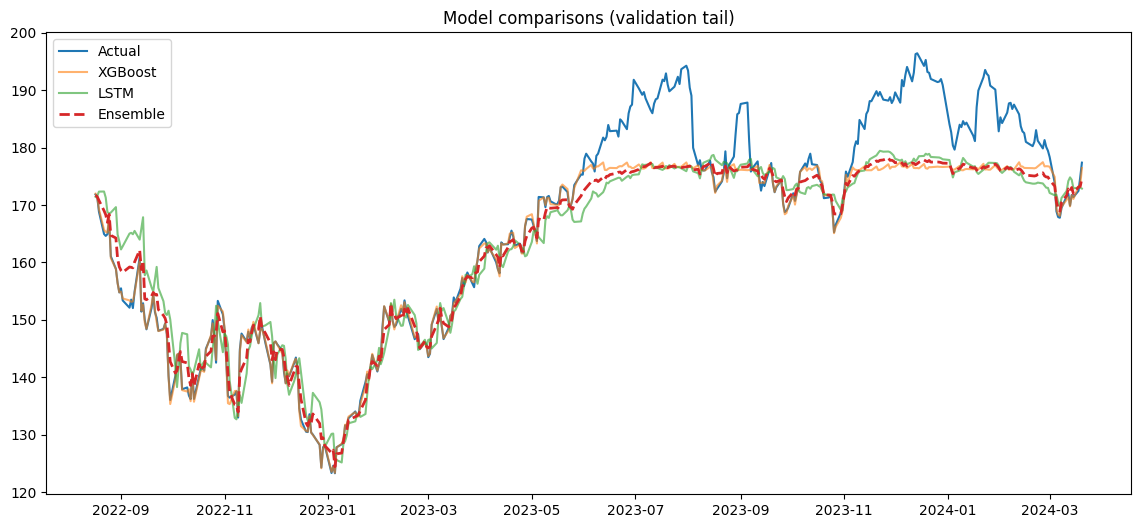

In [16]:
# Plot actual vs predicted on validation tail
plt.figure(figsize=(14,6))
plt.plot(val_df.index[-min_len:], y_true_ens, label='Actual')
plt.plot(val_df.index[-min_len:], xgb_pred[-min_len:], alpha=0.6, label='XGBoost')
plt.plot(val_df.index[-min_len:], lstm_pred[-min_len:], alpha=0.6, label='LSTM')
plt.plot(val_df.index[-min_len:], ensemble_preds, linewidth=2, linestyle='--', label='Ensemble')
plt.legend(); plt.title("Model comparisons (validation tail)")
plt.show()


## 13.Conclusions & Next steps

- **Baselines are essential.** Naive and moving-average baselines set the minimum bar; complex models must outperform them consistently (preferably under walk-forward).
- **Feature engineering matters.** Lag features, rolling stats and calendar features significantly boost tree-based models like XGBoost.
- **Deep learning needs careful setup.** LSTM models can outperform classical models but require more tuning, longer training and GPU acceleration.
- **Ensembling improves stability.** Averaging diverse models usually reduces variance.

**Next steps**
- Add more technical indicators (RSI, MACD), or use `ta` / `pandas_ta`.
- Hyperparameter tuning (Optuna for XGBoost, KerasTuner for NN).
- Multi-step forecasting (predict next 7 days) using seq2seq or direct multi-output setups.
- Add exogenous features: macro data, news sentiment, volume features, options-implied vol.
- Productionize: build inference pipeline and Docker container; test in a paper-trading environment (paper money).
